# Informed Search
The informed strategies uses problem-specific knowledge beyond its definition to search through the search space to find the solution efficiently. 

The general approach is called **best-first search**, in which a node is chosen for expansion based on an **evaluation function** $f(n)$, that estimate the cost, so the node with the lowest value is expanded first. 

So the general implementation of the fringe is with a priority queue ordered by $f(n)$, like in Uniform-cost Search.

# Problem

Most best-first algorithms use a **heuristic function** $h(n)$, that estimates the cost of the cheapest path from the state n to the goal state.

The heuristic is always non-negative, problem-specific and $h(n) = 0$ if n is a goal node.

The problem formulation is slightly different, since we need a heuristic implement in the problem the heuristic function.

In [1]:
class Problem:
    def __init__(self, initial_state, goal_state=None):
        self.initial_state = initial_state
        self.goal_state = goal_state

    def successors(self, state):
        pass

    def actions(self, state):
        pass

    def result(self, state, action):
        pass

    def goal_test(self, state):
        if isinstance(self.goal_state, list):
            return state in self.goal_state
        else:
            return state == self.goal_state

    def cost(self, state, action):
        return 1

    def heuristic(self, state):
        pass

We reuse the implementation for the node, tree search and graph search.
In particular, we focus on the graph search version.

In [2]:
from search.graph_search import GraphSearch

## Example: Street Problem

For this example we use the streets problem that we have seen before, so the environment remain the same:

In [3]:
streets = {
    'Andria': {'Corato': 3, 'Trani': 2},
    'Corato': {'Andria': 3, 'Ruvo': 2, 'Trani': 3, 'Altamura': 4},
    'Altamura': {'Corato': 4, 'Ruvo': 3, 'Modugno': 5},
    'Ruvo': {'Corato': 2, 'Bisceglie': 3, 'Terlizzi': 2, 'Altamura': 3},
    'Terlizzi': {'Ruvo': 2, 'Molfetta': 2, 'Bitonto': 2},
    'Bisceglie': {'Trani': 2, 'Ruvo': 3, 'Molfetta': 2},
    'Trani': {'Andria': 2, 'Corato': 3, 'Bisceglie': 2},
    'Molfetta': {'Bisceglie': 2, 'Giovinazzo': 2, 'Terlizzi': 2},
    'Giovinazzo': {'Molfetta': 2, 'Modugno': 3, 'Bari': 2, 'Bitonto': 3},
    'Bitonto': {'Modugno': 3, 'Giovinazzo': 3, 'Terlizzi': 2},
    'Modugno': {'Bitonto': 3, 'Giovinazzo': 3, 'Bari': 2, 'Altamura': 5, 'Bitetto': 1},
    'Bari': {'Modugno': 2, 'Giovinazzo': 2, 'Bitetto': 2},
    'Bitetto': {'Bari': 2, 'Modugno': 1},
}

We need to define a heuristic for this problem. For example, we can define the coordinates of the city and use the straight line distance as an estimation of the distance between cities.

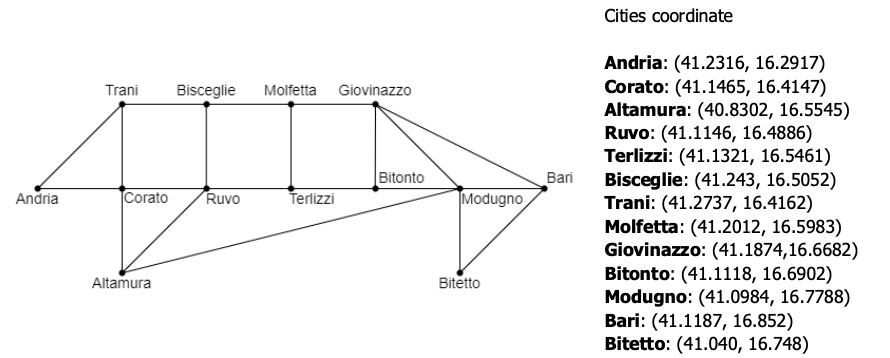

In [4]:
from IPython.display import Image
Image(filename='images/cities_heuristic.png') 

In [5]:
cities_coords = {
    'Andria': (41.2316, 16.2917),
    'Corato': (41.1465, 16.4147),
    'Altamura': (40.8302, 16.5545),
    'Ruvo': (41.1146, 16.4886),
    'Terlizzi': (41.1321, 16.5461),
    'Bisceglie': (41.243, 16.5052),
    'Trani': (41.2737, 16.4162),
    'Molfetta': (41.2012, 16.5983),
    'Giovinazzo': (41.1874, 16.6682),
    'Bitonto': (41.1118, 16.6902),
    'Modugno': (41.0984, 16.7788),
    'Bari': (41.1187, 16.852),
    'Bitetto': (41.040, 16.748)
}

The heuristic function is added to the problem:

In [6]:
import math


class StreetProblem:
    def __init__(self, initial_state, streets, coords, goal_state=None):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.streets = streets
        self.coords = coords

    def successors(self, state):
        actions = self.actions(state)
        return [(self.result(state, action), action) for action in actions]

    def actions(self, state):
        return self.streets[state].keys()

    def result(self, state, action):
        return action

    def goal_test(self, state):
        if isinstance(self.goal_state, list):
            return state in self.goal_state
        else:
            return state == self.goal_state

    def cost(self, state, action):
        return self.streets[state][action]
    
    def heuristic(self, state):
        x_current, y_current = self.coords[state]
        x_goal, y_goal = self.coords[self.goal_state]
        
        return math.sqrt((x_current - x_goal) ** 2 + (y_current - y_goal) ** 2)

# Informed Search Strategies

## Greedy Search

Expand the node that is closest to the goal. 

The evaluation function is just the heuristic: $f(n) = h(n)$

The general idea is to expand first the node that appears closed to the goal.

This algorithm is complete in the graph version if the space is finite, while in the worst case time and space complexity for the tree version is $O(b^m)$

In [7]:
class GreedySearch:
    def __init__(self, problem):
        self.problem = problem
        
    def select(self, fringe):
        fringe = sorted(fringe, key=lambda n: self.problem.heuristic(n.state), reverse=True)
        return fringe, fringe.pop()

we can now try our implementation:

In [8]:
problem = StreetProblem('Bitetto', streets, cities_coords, 'Trani')
search = GraphSearch(problem, GreedySearch(problem))
print(search.run())

('success', ['Modugno', 'Giovinazzo', 'Molfetta', 'Bisceglie', 'Trani'])


## A* Search

Expand the node combining the path cost and the heuristic $f(n) = g(n) + h(n)$.

The idea is to avoid expand paths that are already more expensive.

This algorithm is both complete and optimal. It is optimal if the heuristics is both **admissible** and **consistent**.

- admissible (sufficient for the tree search optimality) → it never over-estimate the cost
- consistent (only for the graph version optimality) → if the triangle inequality is true

The time and space complexity are analyzed base on:

- **absolute error** $\Delta = h^* - h$ where h* is the actual cost
- **relative error** $\epsilon = \frac{h^*-h}{h*}$

So the time and space complexity is $O(b^{\epsilon d})$, the space complexity is the major drawback.

In [9]:
class AStarSearch:
    def __init__(self, problem):
        self.problem = problem
        
    def select(self, fringe):
        fringe = sorted(fringe, key=lambda n: n.cost + self.problem.heuristic(n.state), reverse=True)
        return fringe, fringe.pop()

we can now try our implementation:

In [10]:
problem = StreetProblem('Bitetto', streets, cities_coords, 'Trani')
search = GraphSearch(problem, AStarSearch(problem))
print(search.run())

('success', ['Bari', 'Giovinazzo', 'Molfetta', 'Bisceglie', 'Trani'])


## Example: Eight Puzzle

Also, the Eight puzzle problem can be modified to use informed search strategies.

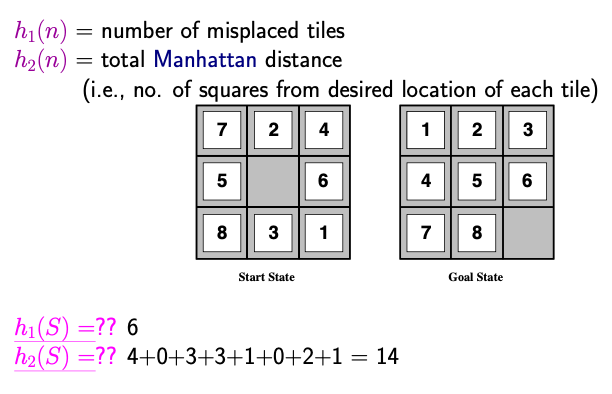

In [11]:
from IPython.display import Image
Image(filename='images/8puzzle_heuristics.png') 

In [12]:
import copy


class EightTilesProblem:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state

    def successors(self, state):
        actions = self.actions(state)
        return [(self.result(state, action), action) for action in actions]

    def result(self, state, action):
        new_state = copy.deepcopy(state)
        pos = new_state.index(0)
        row = pos // 3
        col = pos % 3

        new_row, new_col = row, col

        if action == 'up':
            new_row = row - 1
        if action == 'down':
            new_row = row + 1
        if action == 'left':
            new_col = col - 1
        if action == 'right':
            new_col = col + 1

        new_pos = new_row * 3 + new_col

        new_state[new_pos], new_state[pos] = state[pos], state[new_pos]

        return new_state

    def actions(self, state):
        index = state.index(0)
        row = index // 3
        col = index % 3

        actions = ['up', 'down', 'left', 'right']

        if row < 1:
            actions.remove('up')
        if row >= 2:
            actions.remove('down')
        if col < 1:
            actions.remove('left')
        if col >= 2:
            actions.remove('right')

        return actions

    def goal_test(self, state):
        return self.goal_state == state
    
    def cost(self, state, action):
        return 1

    def heuristic(self, state):
        # number of misplaced tiles
        # in the slide the blank is ignored in the heuristics
        return sum([x != y for x, y in zip(state, self.goal_state) if x != 0])
    
    """
    def heuristic(self, state):
        # total manhattan distance
        distance = 0
        # in the slide the blank is ignored in the heuristics
        for i in range(1, 9):
            current_index = state.index(i)
            current_row = current_index // 3
            current_col = current_index % 3
            goal_index = self.goal_state.index(i)
            goal_row = goal_index // 3
            goal_col = goal_index % 3
            distance += abs(current_row - goal_row) + abs(current_col - goal_col)
            
        return distance
    """

We can try the heuristics:

In [13]:
problem = EightTilesProblem([7, 2, 4, 5, 0, 6, 8, 3, 1], [1, 2, 3, 4, 5, 6, 7, 8, 0])
print(problem.heuristic([7, 2, 4, 5, 0, 6, 8, 3, 1]))

6


Now we can try to solve the configuration seen before in the uninformed search: 

In [14]:
problem = EightTilesProblem([1, 2, 3, 4, 0, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8])
search = GraphSearch(problem, GreedySearch(problem))
print(search.run())

('success', ['left', 'up', 'right', 'down', 'left', 'up', 'right', 'right', 'down', 'left', 'left', 'up', 'right', 'right', 'down', 'left', 'left', 'up', 'right', 'right', 'down', 'left', 'up', 'right', 'down', 'left', 'up', 'left', 'down', 'right', 'right', 'up', 'left', 'down', 'left', 'up', 'right', 'right', 'down', 'left', 'up', 'right', 'down', 'left', 'up', 'left'])


In [15]:
problem = EightTilesProblem([1, 2, 3, 4, 0, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8])
search = GraphSearch(problem, AStarSearch(problem))
print(search.run())

('success', ['left', 'up', 'right', 'right', 'down', 'left', 'up', 'left', 'down', 'right', 'right', 'up', 'left', 'left'])
